In [120]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
import sys
import os
sys.path.append("../utility")
sys.path.append("../train")
sys.path.append("../")
from Utility import data_collecter


from Utility import DerivativeLiftFunc, data_collecter,RBFLiftFunc

In [121]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]

In [122]:
method_index = 1
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
suffix = "DampingPendulum1_26"
# env_name = "DampingPendulum"
env_name = "LunarLanderContinuous-v2"
# suffix = "MountainCarContinuous1_26"
# env_name = "MountainCarContinuous-v0"
# env_name = "DoublePendulum"

In [123]:
# Kd = np.load("Prediction_Results/"+"Kd_"+env_name+"_KoopmanRBF"+".npy")
Kd = np.load("../Prediction_Results/Samples/"+"Kd_"+env_name+"_KoopmanRBFsamples{}".format(20000)+".npz")["Kd"]
Data_collecter = data_collecter(env_name)
Nstate = Data_collecter.Nstates
udim = Data_collecter.udim
Nrbf = 50
LiftFunc = RBFLiftFunc(env_name,Nstate,udim,Nrbf,Data_collecter.observation_space)
NKoopman = LiftFunc.NKoopman

In [124]:

def Cost(observations,u_list,Q,R,x_ref):
    steps = observations.shape[1]
    loss = 0
    state_dim = x_ref.shape[0]
    for s in range(steps):
        if s!=steps-1:
            ucost = np.dot(np.dot(u_list[s].T,R),u_list[s])
            loss += ucost[0,0]
        xcost = np.dot(np.dot((observations[:,s]-x_ref).T,Q[:state_dim,:state_dim]),(observations[:,s]-x_ref))
        loss += xcost[0,0]
    return loss
def Prepare_LQR(env_name):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        R = 0.001*np.eye(1)
        reset_state=  [0.0,-1.0,0.0,0]
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.001*np.eye(1)
        reset_state = [-3.0,0.5]
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.08*np.eye(1)
        reset_state = [-3,2]   
    elif env_name.startswith("DoublePendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 5.0
        Q[2,2] = 0
        Q[3,3] = 0
        R = 0.001*np.eye(2)
        reset_state = [-1.5, 0.1, 0, 0]
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.001*np.eye(1)
        reset_state = [0.5,0.0]  
        x_ref[0] = 0.45
    elif env_name.startswith("LunarLanderContinuous-v2"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 20.0
        Q[1,1] = 20.0
        Q[2,2] = 5.0
        Q[3,3] = 5.0
        R = 0.001*np.eye(2)
        reset_state = [2.0,0.0]  
        x_ref[0] = 0
        x_ref[1] = 0
        x_ref[-1] = 0
        x_ref[-2] = 0
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref

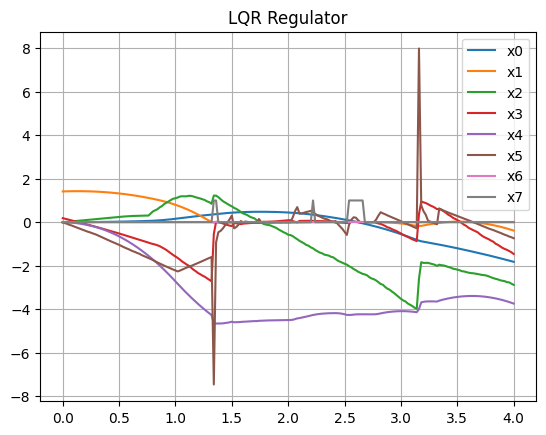

Total cost:  31150.396850659105


In [125]:
Ad = Kd[:NKoopman,:NKoopman]
Bd = Kd[:NKoopman,NKoopman:]
env = Data_collecter.env
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
observation_list = []
if env_name == "LunarLanderContinuous-v2":
    observation = env.reset()
else:
    observation = env.reset_state(reset_state)
observation = np.array(observation)
x0 = np.matrix(LiftFunc.Psi_s(observation))
# x_ref_lift = LiftFunc.Psi_s(x_ref).reshape(NKoopman,1)
x_ref_lift = LiftFunc.Psi_s(x_ref).reshape(1,NKoopman)
observation_list.append(x0.T[:Nstate].reshape(-1,1))
# print(Kopt)
u_list = []
steps = 200
# umax = 100
for i in range(steps):
    # env.render()
    # print((x0-x_ref_lift).reshape(NKoopman))
    u = -Kopt*((x0-x_ref_lift).reshape(NKoopman, 1))
    if udim == 1:
        ureal = u[0,0]
    else:
        ureal = [u[i,0] for i in range(udim)]
    # u = max(-umax,min(umax,u[0,0]))
    # print(type(u[0,0]),type(u))
    observation, reward, done, info = env.step(ureal)
    x0 = np.matrix(LiftFunc.Psi_s(observation))
    # x0 = Ad*x0+Bd*u
    observation_list.append(x0.T[:Nstate].reshape(-1,1))
    u_list.append(u)
    # time.sleep(0.1)

observations = np.concatenate(observation_list,axis=1)
np.save("./data/"+env_name+"_KoopmanRBF"+"_observations.npy",observations)
u_list = np.array(u_list).reshape(-1)
time_history = np.arange(steps+1)*env.dt
for i in range(Nstate):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
plt.grid(True)
plt.title("LQR Regulator")
plt.legend()
plt.show()
cost = Cost(observations,u_list,Q,R,x_ref)
print("Total cost: ",cost)

测试回合  1/100 | 得分：-467.2 | 步数： 57 | 落地：(x=-0.062, y=-0.007)
测试回合  2/100 | 得分：-454.9 | 步数： 62 | 落地：(x=0.341, y=0.049)
测试回合  3/100 | 得分：-450.6 | 步数： 52 | 落地：(x=-0.302, y=0.031)
测试回合  4/100 | 得分：-388.4 | 步数： 52 | 落地：(x=-0.038, y=0.005)
测试回合  5/100 | 得分：-644.4 | 步数： 75 | 落地：(x=-0.436, y=-0.049)
测试回合  6/100 | 得分：-459.3 | 步数： 73 | 落地：(x=0.139, y=0.002)
测试回合  7/100 | 得分：-477.6 | 步数： 72 | 落地：(x=0.079, y=0.008)
测试回合  8/100 | 得分：-346.5 | 步数： 50 | 落地：(x=-0.003, y=0.017)
测试回合  9/100 | 得分：-560.3 | 步数： 62 | 落地：(x=-0.128, y=0.009)
测试回合 10/100 | 得分：-418.9 | 步数： 91 | 落地：(x=-0.653, y=-0.058)
测试回合 11/100 | 得分：-377.2 | 步数： 55 | 落地：(x=0.214, y=-0.011)


测试回合 12/100 | 得分：-538.6 | 步数： 63 | 落地：(x=-0.561, y=-0.021)
测试回合 13/100 | 得分：-421.3 | 步数： 54 | 落地：(x=-0.089, y=-0.008)
测试回合 14/100 | 得分：-423.2 | 步数： 54 | 落地：(x=-0.109, y=-0.007)
测试回合 15/100 | 得分：-535.5 | 步数： 59 | 落地：(x=-0.280, y=0.032)
测试回合 16/100 | 得分：-433.8 | 步数： 83 | 落地：(x=-0.336, y=0.002)
测试回合 17/100 | 得分：-530.0 | 步数： 71 | 落地：(x=-0.636, y=-0.062)
测试回合 18/100 | 得分：-532.1 | 步数： 58 | 落地：(x=-0.311, y=-0.031)
测试回合 19/100 | 得分：-430.5 | 步数： 51 | 落地：(x=-0.268, y=0.035)
测试回合 20/100 | 得分：-565.6 | 步数： 71 | 落地：(x=0.319, y=-0.038)
测试回合 21/100 | 得分：-460.5 | 步数： 56 | 落地：(x=-0.129, y=-0.008)
测试回合 22/100 | 得分：-590.1 | 步数： 64 | 落地：(x=-0.235, y=0.036)
测试回合 23/100 | 得分：-454.0 | 步数： 66 | 落地：(x=-0.536, y=0.203)
测试回合 24/100 | 得分：-528.3 | 步数： 71 | 落地：(x=-0.037, y=0.000)
测试回合 25/100 | 得分：-395.5 | 步数： 50 | 落地：(x=-0.194, y=0.006)
测试回合 26/100 | 得分：-437.7 | 步数： 80 | 落地：(x=-0.345, y=0.011)
测试回合 27/100 | 得分：-510.2 | 步数： 67 | 落地：(x=-0.129, y=0.008)
测试回合 28/100 | 得分：-357.7 | 步数： 53 | 落地：(x=0.106, y=0.017)
测试回合 29/1

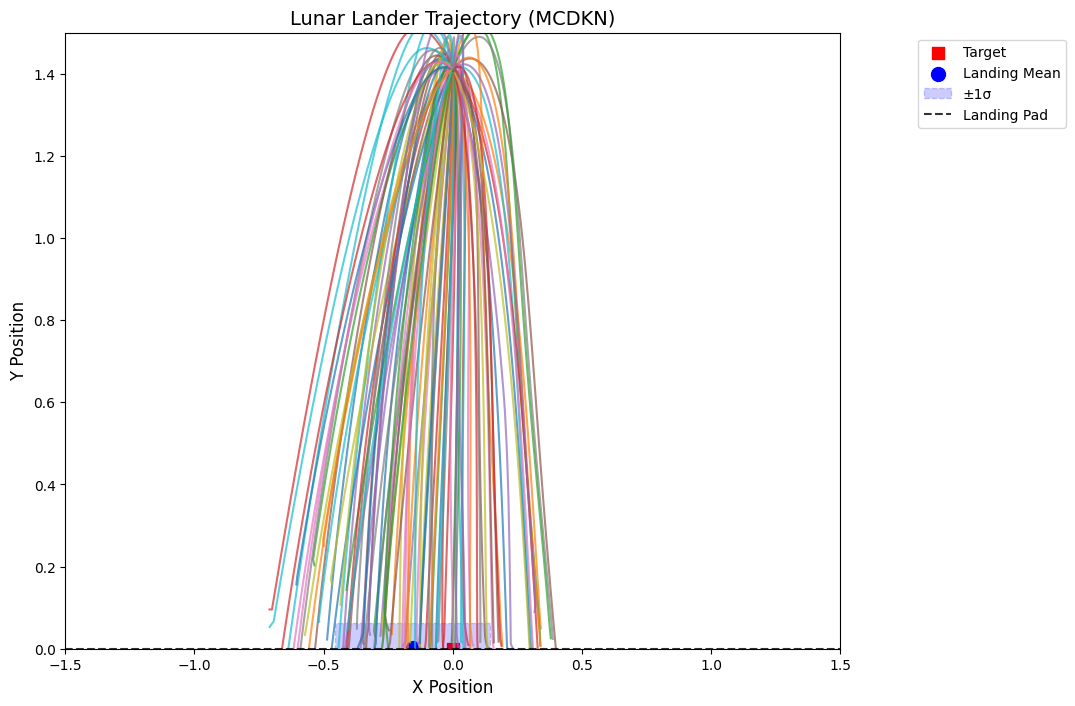


=== 测试总结 ===
平均得分：-523.8±121.9 | 成功着陆：86/100


In [126]:
from typing import Tuple, List
def test_lander_lqr(
    net,  # 修正类型：适配DKN_MC2
    K_lqr,
    x_ref,
    num_episodes: int = 100,
    max_steps: int = 200,
    version: str = "MCDKN",
    seed: int = 2022
) -> List[float]:
    # 原函数逻辑不变，仅修正psi类型注解
    env = gym.make("LunarLanderContinuous-v2")
    env.seed(seed)
    # device = next(net.parameters()).device
    episode_scores: List[float] = []
    all_trajectories: List[List[Tuple[float, float]]] = []
    landing_positions: List[Tuple[float, float]] = []
    success_count = 0
    # net.eval()
    with torch.no_grad():
        for ep in range(num_episodes):
            observation = env.reset()
            done = False
            total_score = 0.0
            step = 0
            trajectory = []
            x0 = np.matrix(net.Psi_s(observation))
            x_ref_lift = net.Psi_s(x_ref)

            while not done and step < max_steps:
                x0 = x0.T
                trajectory.append((x0[0,0], x0[1,0]))
                # env.render()
                u = -Kopt*(x0-x_ref_lift)
                if udim == 1:
                    ureal = u[0,0]
                else:
                    ureal = [u[i,0] for i in range(udim)]
                # u = max(-umax,min(umax,u[0,0]))
                # print(type(u[0,0]),type(u))
                observation, reward, done, info = env.step(ureal)
                x0 = np.matrix(net.Psi_s(observation))
                # x0 = Ad*x0+Bd*u
                total_score += reward
                step += 1
            x0 = x0.T
            landing_x, landing_y = x0[0,0], x0[1,0]
            landing_positions.append((landing_x, landing_y))
            trajectory.append((landing_x, landing_y))
            all_trajectories.append(trajectory)
            episode_scores.append(total_score)
            if abs(landing_x) <= 0.5 and -0.2 <= landing_y <= 0.2:
                success_count += 1
            print(f"测试回合 {ep+1:2d}/{num_episodes} | 得分：{total_score:5.1f} | 步数：{step:3d} | 落地：(x={landing_x:.3f}, y={landing_y:.3f})")

    env.close()
    # 原落地统计与绘图逻辑不变...
    landing_xs = np.array([p[0] for p in landing_positions], dtype=np.float32)
    landing_ys = np.array([p[1] for p in landing_positions], dtype=np.float32)
    mean_x = np.mean(landing_xs)
    mean_y = np.mean(landing_ys)
    var_x = np.var(landing_xs, ddof=1)
    var_y = np.var(landing_ys, ddof=1)
    std_x = np.sqrt(var_x)
    std_y = np.sqrt(var_y)

    print(f"\n=== 落地位置统计 ===")
    x_ref_np = x_ref
    print(f"目标：(x={x_ref_np[0]:.3f}, y={x_ref_np[1]:.3f}) | 均值：(x={mean_x:.3f}, y={mean_y:.3f})")
    print(f"方差：var_x={var_x:.6f}, var_y={var_y:.6f} | 标准差：std_x={std_x:.3f}, std_y={std_y:.3f}")

    # 原轨迹绘图逻辑不变...
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10.colors
    for ep, traj in enumerate(all_trajectories):
        x_coords = [p[0] for p in traj]
        y_coords = [p[1] for p in traj]
        plt.plot(x_coords, y_coords, color=colors[ep % len(colors)], alpha=0.7)

    plt.scatter(x_ref_np[0], x_ref_np[1], color="red", marker="s", s=80, label="Target")
    plt.scatter(mean_x, mean_y, color="blue", marker="o", s=100, label=f"Landing Mean")
    plt.gca().add_patch(plt.Rectangle((mean_x-std_x, mean_y-std_y), 2*std_x, 2*std_y, 
                                     color="blue", alpha=0.2, linestyle="--", label="±1σ"))
    plt.axhline(y=0, color="black", linestyle="--", alpha=0.8, label="Landing Pad")
    plt.xlim(-1.5, 1.5)
    plt.ylim(0, 1.5)
    plt.xlabel("X Position", fontsize=12)
    plt.ylabel("Y Position", fontsize=12)
    plt.title(f"Lunar Lander Trajectory ({version})", fontsize=14)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=10)
    plt.show()
    os.makedirs("./fig/lunarlander", exist_ok=True)
    plt.savefig(f"./fig/lunarlander/trajectory_{version}.png", bbox_inches="tight", dpi=300)
    plt.close()

    avg_score = np.mean(episode_scores)
    std_score = np.std(episode_scores)
    print(f"\n=== 测试总结 ===")
    print(f"平均得分：{avg_score:.1f}±{std_score:.1f} | 成功着陆：{success_count}/{num_episodes}")
    return episode_scores

episode_scores = test_lander_lqr(LiftFunc, Kopt,x_ref)